[🌐 Google Colaboratory Variant](https://colab.research.google.com/drive/1uB1PuT_uNGM2tv88ZDkIj6Dhi_Rf91PA)

In [1]:
%run ../input/python-recipes/cidhtml.py
idhtml('Code Modules, Functions, & Classes')

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np
import h5py,imageio,os,torch,pylab as pl
import tensorflow_hub as th,tensorflow as tf
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image as tkimg
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf
import torch.nn as tnn
from PIL import Image
dev=torch.device('cuda:0' \
if torch.cuda.is_available() else 'cpu')
from IPython.core.magic import register_line_magic
print('tensorflow version:',tf.__version__)

tensorflow version: 2.2.0


In [3]:
def images2array(files_path,img_size,grayscale=False):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if (img_path[-4:]=='.png'):
            img=tkimg.load_img(
                img_path,grayscale=grayscale,
                target_size=(img_size,img_size))
        img=tkimg.img_to_array(np.squeeze(img))
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),dtype='float32')
class HorseBreedsData(tds):
    def __init__(self,csv_path,img_dir,transform=None):
        df=pd.read_csv(csv_path,index_col=0)
        self.img_dir=img_dir
        self.csv_path=csv_path
        self.img_paths=df['path']
        self.y=df['label'].values
        self.transform=transform
    def __getitem__(self,index):
        img=Image.open(os.path\
        .join(self.img_dir,self.img_paths[index]))
        img=img.convert('RGB')
        if self.transform is not None: 
            img=self.transform(img)
        lbl=self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [4]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,3)
        fig=pl.figure(figsize=(9,3))
        for i in range(n,n+4):
            ax=fig.add_subplot(1,4,i-n+1,\
            xticks=[],yticks=[],title=names[labels[i].item()])
            ax.imshow(np.transpose(images[i],(1,2,0)))
        pl.tight_layout(); pl.show()    
        break
@register_line_magic
def display_predict(data):
    if data=='test': x=x_test; y=y_test
    if data=='valid': x=x_valid; y=y_valid 
    kmodel.load_weights(fweights)
    y_predict=kmodel.predict_classes(x)
    fig=pl.figure(figsize=(9,8))
    randch=np.random.choice(
        x.shape[0],size=6,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
        ax.imshow(np.squeeze(x[idx]))
        pred_idx=y_predict[idx]; true_idx=y[idx]
        ti='{} \n({})'.format(
            names[pred_idx],names[true_idx])
        ax.set_title(ti,\
        color=('darkblue' if pred_idx==true_idx else 'darkred'))
    pl.tight_layout(); pl.show()
def show_image(img):
    img=utils.make_grid(img)
    npimg=img.numpy(); tr=(1,2,0)
    pl.figure(figsize=(9,3))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.tight_layout(); pl.show()

In [5]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples
def keras_history_plot(fit_history,fig_size,color='darkblue'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[0,2]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[1,3]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()

In [6]:
idhtml('Data Loaders')

In [7]:
img_path='../input/horse-breeds/'; img_size=160
names=['Akhal-Teke','Appaloosa','Orlov Trotter',
       'Vladimir Heavy Draft','Percheron',
       'Arabian','Friesian']
flist=sorted(os.listdir(img_path))
labels=[int(el[:2])-1 for el in flist]
labels=np.array(labels,dtype='int32')
images=images2array(img_path,img_size)
N=labels.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
              [x_train.dtype,x_valid.dtype,x_test.dtype],
              [y_train.shape,y_valid.shape,y_test.shape],
              [y_train.dtype,y_valid.dtype,y_test.dtype]],               
             columns=['train','valid','test'])

=>=>=>=>=>=>=>=>=>=>

,train,valid,test
0,"(536, 160, 160, 3)","(67, 160, 160, 3)","(67, 160, 160, 3)"
1,float32,float32,float32
2,"(536,)","(67,)","(67,)"
3,int32,int32,int32


In [8]:
train_csv,valid_csv,test_csv=\
'train.csv','valid_csv','test.csv'
img_path2='../input'; img_size2=64
files=[os.path.relpath(os.path.join(dirpath,fn),img_path2) \
for (dirpath,dirnames,filenames) in os.walk(img_path2) \
for fn in filenames if fn.endswith('.png')]
d={'label':[],'breed':[],'file':[],'path':[]}
for f in files:
    _,fn=f.split('/')
    label=int(fn[:2])-1; breed=names[label]        
    d['label'].append(label)
    d['breed'].append(breed)
    d['file'].append(fn)
    d['path'].append(f)
df=pd.DataFrame.from_dict(d)
np.random.seed(123)
ids=np.random.rand(len(df))<.8
df_train=df[ids]; df_test=df[~ids]
df_train.set_index('file',inplace=True)
df_train.to_csv(train_csv)
df_test.set_index('file',inplace=True)
df_test[:df_test.shape[0]//2].to_csv(test_csv)
df_test[df_test.shape[0]//2:].to_csv(valid_csv)
num_classes=np.unique(df['label'].values).shape[0]
print([num_classes,len(files)]); df_test.head()

[7, 670]


,label,breed,path
file,,,
06_042.png,5,Arabian,horse-breeds/06_042.png
01_049.png,0,Akhal-Teke,horse-breeds/01_049.png
03_034.png,2,Orlov Trotter,horse-breeds/03_034.png
02_021.png,1,Appaloosa,horse-breeds/02_021.png
06_054.png,5,Arabian,horse-breeds/06_054.png


In [9]:
batch_size=16; num_workers=4; grayscale=False
trans=transforms\
.Compose([transforms.Resize((img_size2,img_size2)),
          transforms.ToTensor()])
train=HorseBreedsData(
    csv_path=train_csv,img_dir=img_path2,transform=trans)
test=HorseBreedsData(
    csv_path=test_csv,img_dir=img_path2,transform=trans)
valid=HorseBreedsData(
    csv_path=valid_csv,img_dir=img_path2,transform=trans)
dataloaders={'train':tdl(dataset=train,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers),
             'test':tdl(dataset=test,batch_size=batch_size,
                        shuffle=True,num_workers=num_workers),
             'valid':tdl(dataset=valid,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers)}

Image dimensions: torch.Size([16, 3, 64, 64])
Label dimensions: torch.Size([16])


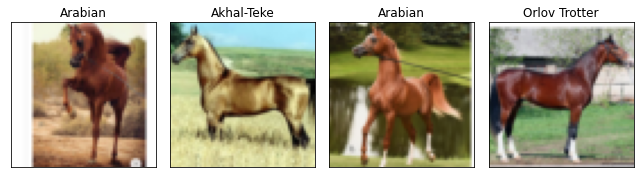

In [10]:
%display_examples valid

In [11]:
idhtml('Classifiers')

In [12]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=Sequential([
        tkl.Input((pix,pix,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.25),
        tkl.Dense(512,activation='relu'),
        tkl.Dropout(rate=.25),
        tkl.Dense(lbl,activation=activ)])
    model.compile(
        optimizer='adam',metrics=['accuracy'],loss=loss)
    return model
def cb(fw):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(
        filepath=fw,save_best_only=True,verbose=2,
        save_weights_only=True,monitor='val_accuracy',mode='max')
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [13]:
fweights='/checkpoints'
handle_base='mobilenet_v2_100_160'
mhandle='https://tfhub.dev/google/imagenet/'+\
        '{}/classification/4'.format(handle_base)
kmodel=premodel(img_size,4096,mhandle,7,'softmax',
                'sparse_categorical_crossentropy')
history=kmodel.fit(
    x=x_train,y=y_train,batch_size=32,epochs=50,
    callbacks=cb(fweights),validation_data=(x_valid,y_valid))

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.8431 - accuracy: 0.5261
Epoch 00001: val_accuracy improved from -inf to 0.62687, saving model to /checkpoints
17/17 [==============================] - 3s 191ms/step - loss: 1.8431 - accuracy: 0.5261 - val_loss: 5.5785 - val_accuracy: 0.6269 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.7929
Epoch 00002: val_accuracy did not improve from 0.62687
17/17 [==============================] - 1s 87ms/step - loss: 0.7643 - accuracy: 0.7929 - val_loss: 8.0184 - val_accuracy: 0.5821 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.7976 - accuracy: 0.8265
Epoch 00003: val_accuracy did not improve from 0.62687
17/17 [==============================] - 1s 87ms/step - loss: 0.7976 - accuracy: 0.8265 - val_loss: 2.7215 - val_accuracy: 0.5672 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.871

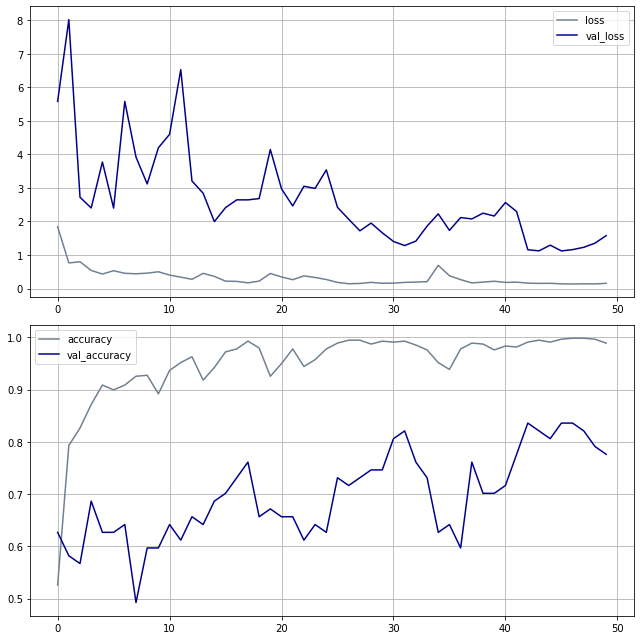

In [14]:
keras_history_plot(history,9)

In [15]:
kmodel.load_weights(fweights)
kmodel.evaluate(x_test,y_test,verbose=0)

[0.7839173078536987, 0.8656716346740723]

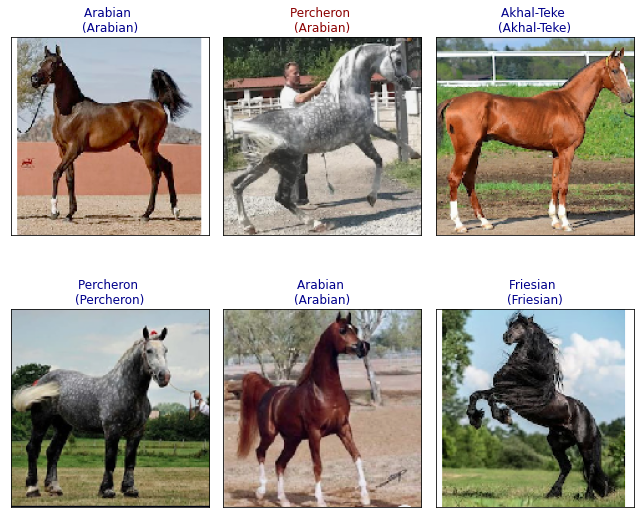

In [16]:
%display_predict test

In [17]:
def kmodel(leaky_alpha):
    model=Sequential()
    model.add(tkl.Conv2D(
        32,(5,5),padding='same', 
        input_shape=(img_size,img_size,3)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(196,(5,5)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))   
    model.add(tkl.GlobalMaxPooling2D())     
    model.add(tkl.Dense(1024))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))
    model.add(tkl.Dropout(.5))     
    model.add(tkl.Dense(7))
    model.add(tkl.Activation('softmax'))   
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
kmodel=kmodel(.02)

In [18]:
history=kmodel.fit(
    x_train,y_train,epochs=200,batch_size=64,
    validation_data=(x_valid,y_valid),
    verbose=2,callbacks=cb(fweights))

Epoch 1/200

Epoch 00001: val_accuracy improved from -inf to 0.20896, saving model to /checkpoints
9/9 - 1s - loss: 1.9146 - accuracy: 0.1511 - val_loss: 1.9002 - val_accuracy: 0.2090 - lr: 0.0010
Epoch 2/200

Epoch 00002: val_accuracy did not improve from 0.20896
9/9 - 1s - loss: 1.8751 - accuracy: 0.1698 - val_loss: 1.8733 - val_accuracy: 0.1791 - lr: 0.0010
Epoch 3/200

Epoch 00003: val_accuracy improved from 0.20896 to 0.41791, saving model to /checkpoints
9/9 - 1s - loss: 1.8588 - accuracy: 0.2556 - val_loss: 1.8350 - val_accuracy: 0.4179 - lr: 0.0010
Epoch 4/200

Epoch 00004: val_accuracy did not improve from 0.41791
9/9 - 1s - loss: 1.8057 - accuracy: 0.2780 - val_loss: 1.8070 - val_accuracy: 0.4030 - lr: 0.0010
Epoch 5/200

Epoch 00005: val_accuracy did not improve from 0.41791
9/9 - 1s - loss: 1.7294 - accuracy: 0.3265 - val_loss: 1.8009 - val_accuracy: 0.4030 - lr: 0.0010
Epoch 6/200

Epoch 00006: val_accuracy improved from 0.41791 to 0.52239, saving model to /checkpoints
9/9

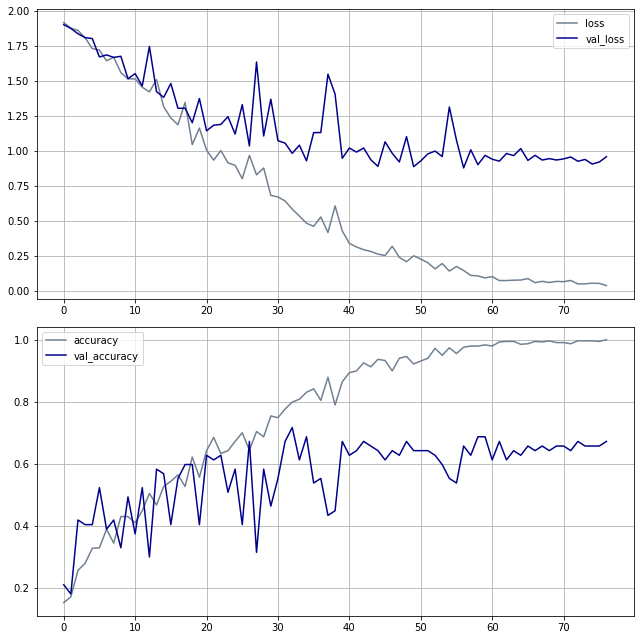

In [19]:
keras_history_plot(history,9)

In [20]:
kmodel.load_weights(fweights)
kmodel.evaluate(x_test,y_test,verbose=0)

[0.9971573352813721, 0.5970149040222168]

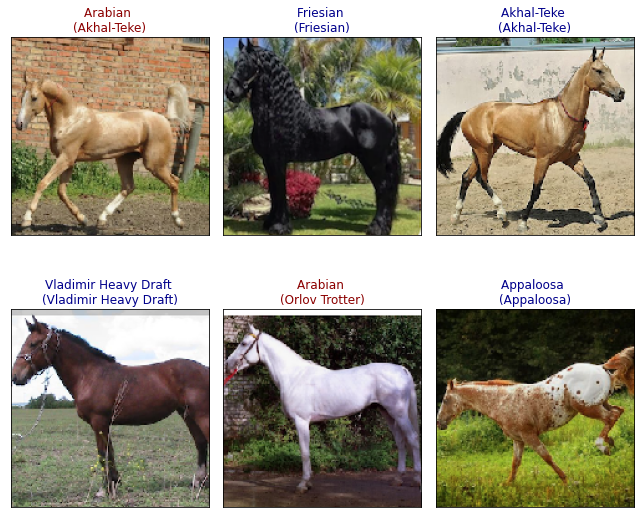

In [21]:
%display_predict test

In [22]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters():
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [23]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%10:
                print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids,
                         len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d'%(epoch+1,epochs))
            print('train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [24]:
%train_run 11

Epoch: 001/011 | Batch: 000/034 | Cost: 1.9001
Epoch: 001/011 | Batch: 010/034 | Cost: 1.8620
Epoch: 001/011 | Batch: 020/034 | Cost: 2.4438
Epoch: 001/011 | Batch: 030/034 | Cost: 2.3007
Epoch: 001/011
train acc/loss: 60.93%/1.08 valid acc/loss: 57.35%/1.31
Epoch: 002/011 | Batch: 000/034 | Cost: 1.3741
Epoch: 002/011 | Batch: 010/034 | Cost: 1.5216
Epoch: 002/011 | Batch: 020/034 | Cost: 0.9345
Epoch: 002/011 | Batch: 030/034 | Cost: 1.6331
Epoch: 002/011
train acc/loss: 69.91%/0.85 valid acc/loss: 54.41%/1.25
Epoch: 003/011 | Batch: 000/034 | Cost: 1.1635
Epoch: 003/011 | Batch: 010/034 | Cost: 1.1236
Epoch: 003/011 | Batch: 020/034 | Cost: 1.5203
Epoch: 003/011 | Batch: 030/034 | Cost: 1.8541
Epoch: 003/011
train acc/loss: 78.88%/0.74 valid acc/loss: 57.35%/1.21
Epoch: 004/011 | Batch: 000/034 | Cost: 1.3426
Epoch: 004/011 | Batch: 010/034 | Cost: 0.6597
Epoch: 004/011 | Batch: 020/034 | Cost: 0.5733
Epoch: 004/011 | Batch: 030/034 | Cost: 0.9276
Epoch: 004/011
train acc/loss: 78.1

In [25]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% || test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 89.53% || test acc: 40.30%


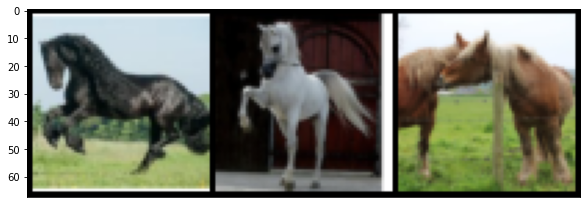


true labels: 
                 Friesian                 Arabian               Percheron

predictions: 
                 Friesian                 Arabian              Akhal-Teke


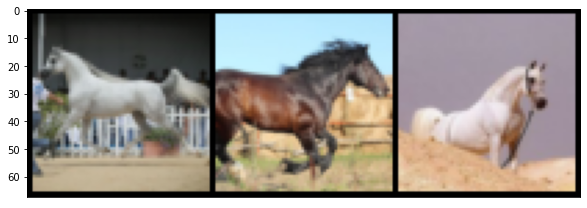


true labels: 
                  Arabian    Vladimir Heavy Draft                 Arabian

predictions: 
                  Arabian              Akhal-Teke              Akhal-Teke


In [26]:
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders['test']):
        show_image(images[:3])
        print('\ntrue labels: \n',
              ''.join('%24s'%names[labels[j]] for j in range(3)))
        images=images.to(dev)
        labels=labels.to(dev)
        outputs=tmodel(images)
        _,preds=torch.max(outputs,int(1))
        print('\npredictions: \n',
             ''.join('%24s'%names[preds[j]] for j in range(3)))
        if i==1: break